In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Lecture 09
## Introduction to Pytorch - Framework Demo
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset
- pytorch implementation Custom Dataset Class with loader


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from time import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder

#import tensorflow as tf
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

#from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir ="D:\DNN\input"
outDir = '../output'
modelDir = 'D:\DNN\models'
SubDir = 'ionosphere'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 500 # number of epochs
BATCH_SIZE = 16
ALPHA = 0.001 # learning rate
#TEST_SIZE = 0.2
TRAIN_SIZE = int(17*BATCH_SIZE)
WEIGHT_DECAY = 0.001
PATIENCE  = 30
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.brg

plt.rcParams.update(params)

## Read ionosphere data set


In [4]:
data_df = pd.read_csv(os.path.join(inpDir, SubDir, 'ionosphere.data'), header = None)
data_df.shape

(351, 35)

In [5]:

data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [6]:
X = data_df.drop(data_df.columns[-1], axis = 1).to_numpy()

y = data_df[data_df.columns[-1]].to_numpy()

In [7]:
train_df, test_df = train_test_split( data_df,
                                     train_size = TRAIN_SIZE,
                                     stratify=data_df[data_df.columns[-1]],
                                     random_state=RANDOM_STATE)

train_df.shape, test_df.shape

((272, 35), (79, 35))

## All about CUDA

In [8]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [9]:
## Singleton Class

In [10]:
'''Using Singleton design pattern'''

class Transformers:
    _instance = None
    
    def __init__ (self):
        if Transformers._instance is not None:
            raise Exception ("GlobalScaler class is a singleton.")
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = Transformers()
        return cls._instance

In [11]:
'''
In this code, we define a custom dataset called Io that takes a DataFrame as input. 

'''

class IonoDS(Dataset):
    transformers = Transformers.get_instance() # private instance variable
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device, 
                 is_train = True,
                 label_col = None
                ):
        super(IonoDS , self).__init__()
        
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.transformers.scaler
        self.label_col = label_col
        self.encoder = self.transformers.encoder
        
        y = self.df[self.label_col].to_numpy()
        X = self.df.drop(self.label_col, axis = 1).to_numpy()
        
        if self.is_train:
            self.labels = self.encoder.fit_transform(y) # fit transform train set 
            self.features = self.scaler.fit_transform(X) # fit transform train set 

        else:
            self.features = self.scaler.transform(X) # transform only test set 
            self.labels = self.encoder.transform(y)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, 
                                dtype=torch.float32, 
                                device=self.device)
        
        label = torch.tensor(label, 
                             dtype=torch.int64, 
                             device=self.device)
        
        return features, label

In [12]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.dor1= 0.5
        self.dor2= 0.1
        self.dor3= 0.15
 
        self.layer1 = nn.Linear(input_dim,26)
        self.bn1 = nn.BatchNorm1d(26)
        self.activ1 = nn.ReLU()
        self.dropout1 = nn.Dropout(self.dor1)

        self.layer2 = nn.Linear(26, 18)
        self.bn2 = nn.BatchNorm1d(18)
        self.activ2 = nn.ReLU()
        self.dropout2 = nn.Dropout(self.dor2)

        self.layer3 = nn.Linear(18, 10)
        self.bn3 = nn.BatchNorm1d(10)
        self.activ3 = nn.ReLU()
        self.dropout3 = nn.Dropout(self.dor3)

        self.layer4 = nn.Linear(10, 2)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.activ3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        return self.softmax(x)


In [13]:
input_shape = 34
model = Model(input_dim=input_shape).to(device) # Create model on GPU
print (model)

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ3): ReLU()
  (dropout3): Dropout(p=0.15, inplace=False)
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [14]:
label_col = 34

train_ds = IonoDS(train_df, is_train=True, label_col=label_col)

test_ds = IonoDS(test_df, is_train=False, label_col=label_col)


In [15]:
train_ds

In [16]:
train_loader = DataLoader(train_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(test_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

In [17]:
XX , yy = next(iter(train_loader)) 
XX.shape , yy.shape

(torch.Size([16, 34]), torch.Size([16]))

In [18]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA , weight_decay= WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=LR_FACTOR , patience=LR_PATIENCE,                                         
                                                     min_lr=0.00001)

minLoss = float('inf') 
savePath = os.path.join(modelDir , SubDir , 'iono.pth')
# Train the model for multiple epochs
counter = 0

for epoch in range(EPOCHS):
    model.train()
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        model.eval()
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    scheduler.step(test_loss)
    
    if test_loss < minLoss:
        minLoss = test_loss
        counter = 0
        torch.save({'epoch' : epoch+1 , 'model_state_dict' :model.state_dict(),'optimizer_state_dict' : optimizer.state_dict(), 'loss' : loss_fn}, savePath)
    else:
        counter += 1
    
    if counter > PATIENCE:
        break

    if epoch%1 == 0:
        print(f'At epoch {epoch:3d} | Loss : {train_loss:.4f}/{test_loss:.4f} ',end=' ')
        print(f'| Acc :{train_acc:.4f}/{test_acc:.4f} | Alpha :{ scheduler.get_last_lr()[0]:.5f} | counter : {counter}')

At epoch   0 | Loss : 0.6999/0.6361  | Acc :0.5662/0.7215 | Alpha :0.00100 | counter : 0
At epoch   1 | Loss : 0.6492/0.5661  | Acc :0.6765/0.8481 | Alpha :0.00100 | counter : 0
At epoch   2 | Loss : 0.5757/0.5076  | Acc :0.7316/0.8481 | Alpha :0.00100 | counter : 0
At epoch   3 | Loss : 0.5925/0.4552  | Acc :0.7169/0.8734 | Alpha :0.00100 | counter : 0
At epoch   4 | Loss : 0.5260/0.4286  | Acc :0.7941/0.8608 | Alpha :0.00100 | counter : 0
At epoch   5 | Loss : 0.5379/0.3924  | Acc :0.7757/0.8608 | Alpha :0.00100 | counter : 0
At epoch   6 | Loss : 0.5023/0.3810  | Acc :0.7904/0.8608 | Alpha :0.00100 | counter : 0
At epoch   7 | Loss : 0.4865/0.3602  | Acc :0.8088/0.8734 | Alpha :0.00100 | counter : 0
At epoch   8 | Loss : 0.4801/0.3412  | Acc :0.8051/0.8861 | Alpha :0.00100 | counter : 0
At epoch   9 | Loss : 0.4409/0.3218  | Acc :0.8272/0.9114 | Alpha :0.00100 | counter : 0
At epoch  10 | Loss : 0.4683/0.3261  | Acc :0.7904/0.8734 | Alpha :0.00100 | counter : 1
At epoch  11 | Loss :

In [19]:
import os
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

###-----------------------------    
### Verify or create a directory
###-----------------------------    
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder
        
        print(_path, ' exists') # advised the user
        
    else:
        
        os.makedirs(_path) # create the path
        
        print("Created folder : ", _path)
        
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


    
###---------------------------------------------------    
### Plot count of classes in training and testing sets
###---------------------------------------------------    
def fn_plot_labels(tr_ds, ts_ds, class_names = None):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))
    
    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1 
    
    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    ax.set_title('Training Set')
        
    # grids make it look good
    ax.grid()


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1 
    
    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)
    
    # add title
    ax.set_title('Test Set')
    

    # grids make it look good
    ax.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

def fn_convert_timestamp(tstr):
    '''
        Function to conver string of form "2015-11-12 1444"
    '''
    
    return datetime.strptime(tstr, "%Y-%m-%d_%H%M")

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = ['loss','val_loss'], ax = ax, colormap=CMAP)

    lossmin = hist_df['loss'].min()

    testmin = hist_df['val_loss'].min()

    # little beautification
    txtstr = "Min Loss: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(lossmin,
                                                                            testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel("Loss")

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = ['accuracy', 'val_accuracy'], ax = ax, colormap=CMAP)
    acc = hist_df['accuracy'].values
    # little beautification
    accmax = hist_df['accuracy'].max()
    testmax = hist_df['val_accuracy'].max()
    txtstr = "Max Accuracy: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(accmax,
                                                                                testmax) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.grid();
    plt.tight_layout()

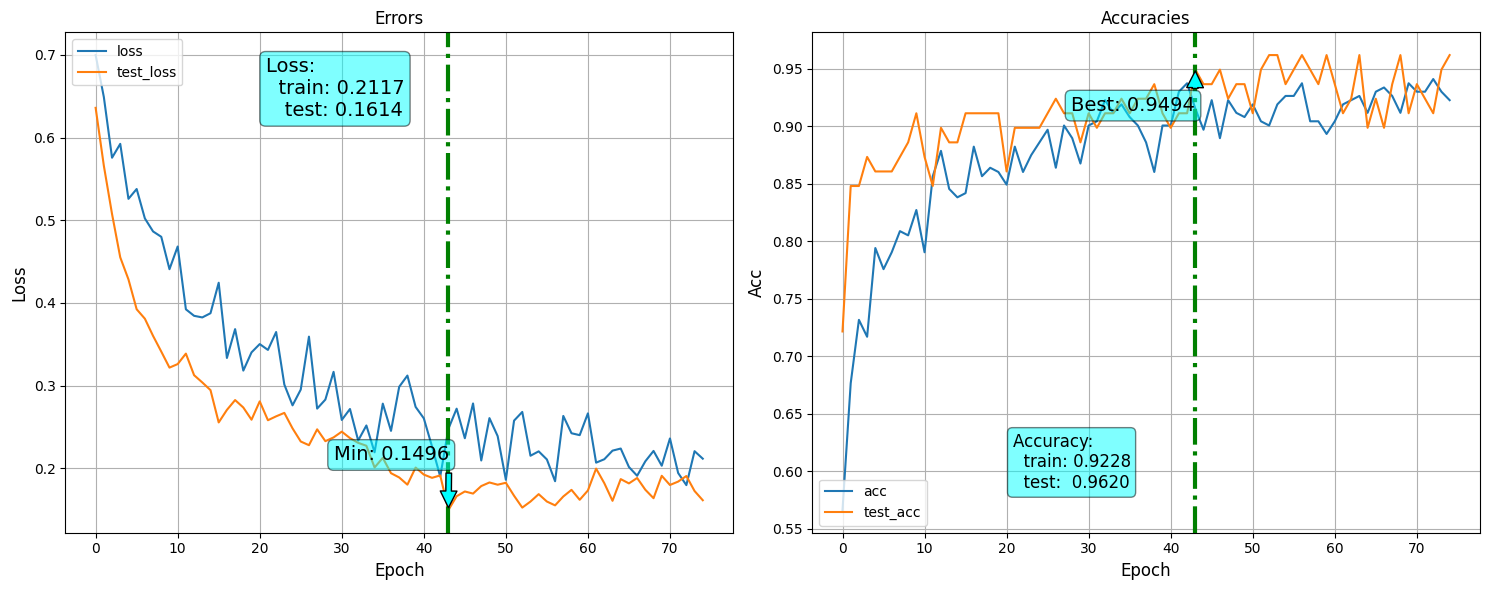

In [27]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
fn_plot_torch_hist(loss_df)


In [21]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [22]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        98
           1       0.96      1.00      0.98       174

    accuracy                           0.97       272
   macro avg       0.98      0.96      0.97       272
weighted avg       0.97      0.97      0.97       272



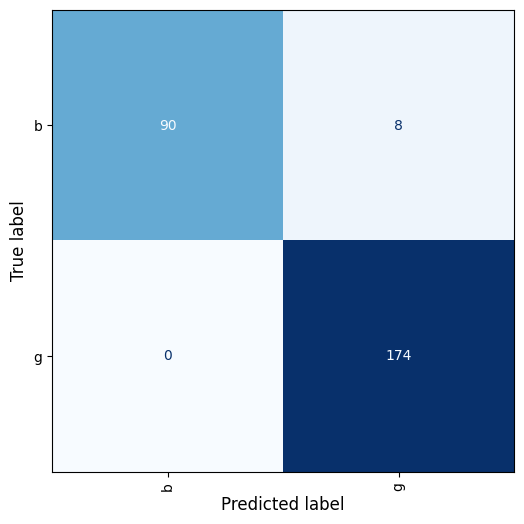

In [23]:
class_labels = {k:v for k,v in enumerate(train_ds.transformers.encoder.classes_)} 
fn_plot_confusion_matrix(y_train, y_pred, class_labels)

In [24]:
y_test = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        98
           1       0.96      1.00      0.98       174

    accuracy                           0.97       272
   macro avg       0.98      0.96      0.97       272
weighted avg       0.97      0.97      0.97       272



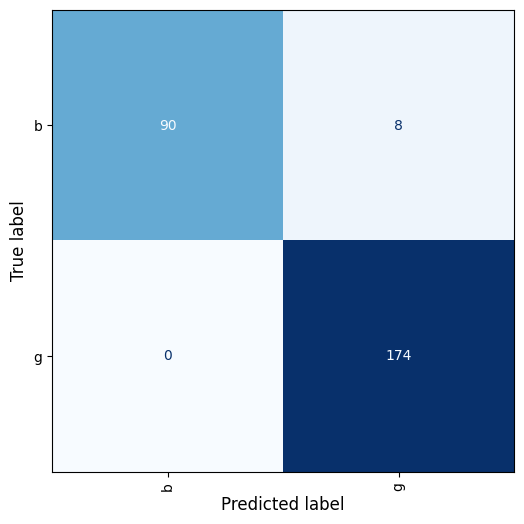

In [26]:
fn_plot_confusion_matrix(y_test, y_pred, class_labels)